# Modules and Constants

In [1]:
# Mathematical operations
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors

# My own functions
from diffusion import *

In [2]:
# Natural constants
kB    = 1.3806485*10**-23  # Boltzmann constant [J/K]

# Simulation parameters
T     = 310

# Box properties and translational diffusion

In [3]:
old_box_data = np.loadtxt("simulations-ANT1-constant-density/results-translation-height/dc_Protein.dat").T
new_box_data = np.loadtxt("simulations-ANT1-height/results-translation/dc_Protein.dat").T
print('number of old simulations:', old_box_data.shape[1])
print('number of new simulations:', new_box_data.shape[1])

number of old simulations: 5
number of new simulations: 36


In [4]:
old_box_edge   = old_box_data[0]
old_box_height = old_box_data[1]

In [5]:
new_box_edge   = new_box_data[0]
new_box_height = new_box_data[1]

# MSD and diffusion coefficients

In [6]:
numblocks = 10
fitstart  = 30 # 50 # 200
fitend    = 60 # 125 # 400

In [7]:
old_msd = []
old_dc  = []
old_err = []

mult    = ['04']
heights = ['07.5','08.5','10.0','11.0','12.5']

# Iterate through the old data
for n_, m_ in enumerate(mult):
    
    for i_, h_ in enumerate(heights):
    
        data = np.loadtxt('simulations-ANT1-constant-density/results-rotation-height/Rotation_Protein_PC60PE40-PC50PE40CL10-1OKC-piece12-mult'+m_+'-height'+h_+'.xvg',comments=['#','@']).T

        # The first column is time
        time = data[0]

        # overwrite the increments with their cumulative sum ( = total rotation in radians)
        rota = np.cumsum(data[1:],axis=1)

        # Calculate MSD and diffusion coefficient with uncertainty
        totdc, diffcoeff, err_diffc, t, msd_i = compute_dc(time,rota,numblocks,fitstart,fitend)

        old_msd.append( msd_i     )
        old_dc.append(  totdc     )
        old_err.append( err_diffc )

# Convert to arrays
old_msd = np.array(old_msd)
old_dc  = np.array(old_dc )
old_err = np.array(old_err)

In [8]:
new_msd = []
new_dc  = []
new_err = []

piece   = ['07']
heights = ['07.5','10.0','12.5','15.0','17.5','20.0']
letter  = ['A','B','C','D','E','F']

# Iterate through the new data
for np_, p_ in enumerate(piece):
    for i_, h_ in enumerate(heights):
        for nl_, l_ in enumerate(letter):

            data = np.loadtxt('simulations-ANT1-height/results-rotation/Rotation_Protein_PC60PE40-PC50PE40CL10-1OKC-piece'+p_+'-mult01-height'+h_+'-'+l_+'.xvg',comments=['#','@']).T

            # The first column is time
            time = data[0]

            # overwrite the increments with their cumulative sum ( = total rotation in radians)
            rota = np.cumsum(data[1:],axis=1)

            # Calculate MSD and diffusion coefficient with uncertainty
            totdc, diffcoeff, err_diffc, t, msd_i = compute_dc(time,rota,numblocks,fitstart,fitend)

            new_msd.append( msd_i   )
            new_dc.append(  totdc     )
            new_err.append( err_diffc )

# Convert to arrays
new_msd = np.array(new_msd)
new_dc  = np.array(new_dc )
new_err = np.array(new_err)

## Average the values from the different trajectories at same size 

In [9]:
def old_average_init(arr):
    arr_av = []
    for i in range(len(arr)):
        arr_av.append( arr[i] )
    return np.array(arr_av)
        
old_edge_av   = old_average_init(old_box_edge)
old_height_av = old_average_init(old_box_height)
old_msd_av    = old_average_init(old_msd)
old_dc_av     = old_average_init(old_dc)
old_err_av    = old_average_init(old_err)

In [10]:
def new_average_init(arr):
    arr_av = []
    for j in range(0,len(arr),6):
        arr_av.append( np.mean(arr[j:j+6], axis=0) )
    arr_av = np.array(arr_av)
    return np.array(arr_av)

new_edge_av   = new_average_init(new_box_edge)
new_height_av = new_average_init(new_box_height)
new_msd_av    = new_average_init(new_msd)
new_dc_av     = new_average_init(new_dc)
new_err_av    = new_average_init(new_err)

# Correct the error estimate for sizes with multiple simulations
new_err_av    = np.array([np.std(new_dc[i:i+6])/np.sqrt(6) for i in range(6)])

In [11]:
print( 'Total simulation time:', time[-1] )
print( 'Total number of frames:', len(time) ) 
ts = time[-1]/(len(time)-1) 
print( 'Time step between two frames:', ts, 'ps' )
blocksize = (len(time)-1)/numblocks
blocktime = blocksize*ts
print( 'Size of one block:', blocksize, 'frames = ', blocktime, 'ps' )

Total simulation time: 2000000.0
Total number of frames: 20001
Time step between two frames: 100.0 ps
Size of one block: 2000.0 frames =  200000.0 ps


## Save the data

In [12]:
np.savetxt('rotation_dc_ant1_old_height.dat',np.array([old_edge_av,old_dc_av,old_err_av]).T,header="# box width [nm], diff. coeff. [rad^2/ps], err(diff. coeff.) [rad^2/ps]" ) 

In [13]:
np.savetxt('rotation_dc_ant1_new_height.dat',np.array([new_edge_av,new_dc_av,new_err_av]).T,header="# box width [nm], diff. coeff. [rad^2/ps], err(diff. coeff.) [rad^2/ps]" ) 

# Figure

In [14]:
old_cmap = plt.cm.viridis
new_cmap = plt.cm.viridis
old_label = '$L = $48 nm\n16 proteins'%np.mean(old_edge_av)
new_label = '$L = $7 nm\n1 protein'%np.mean(new_edge_av)

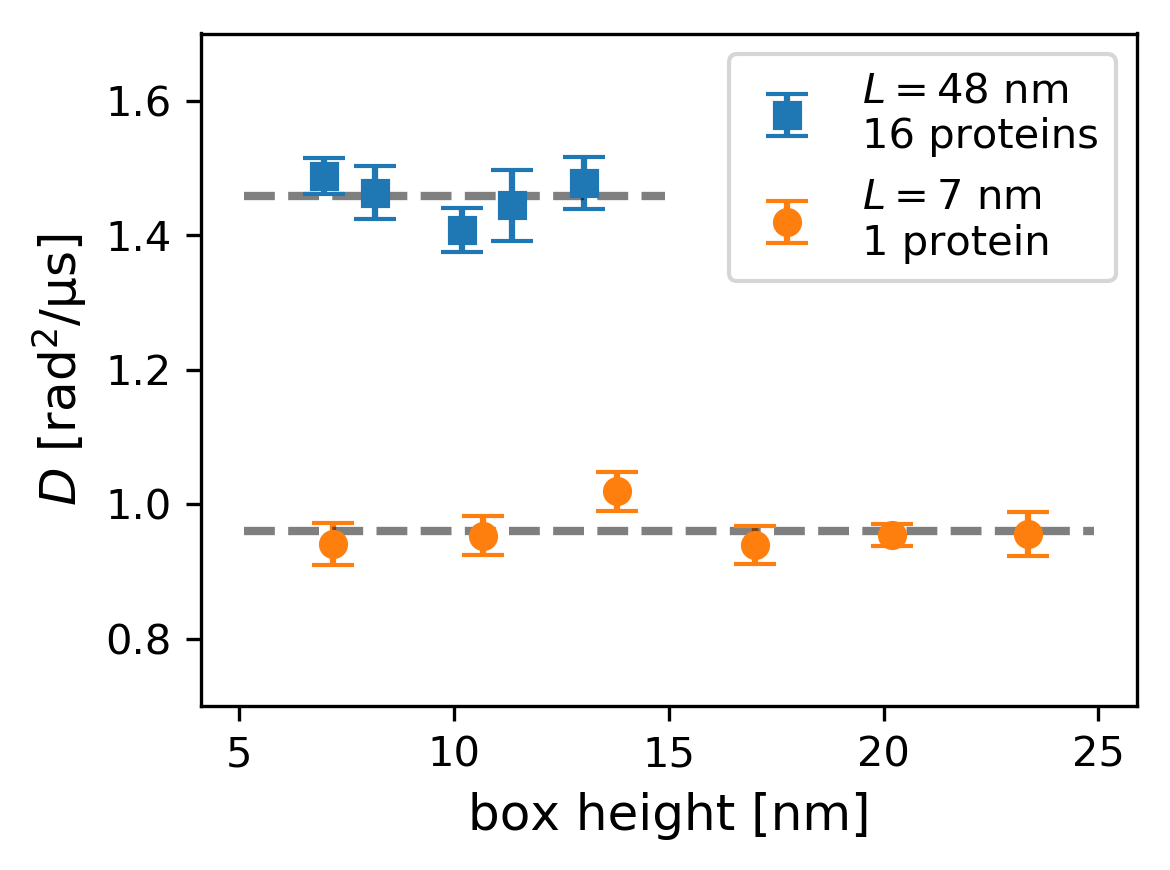

In [15]:
fig, ax = plt.subplots(1,1, figsize=[4,3], dpi=300)

# Fit to theory and limiting value
xax = np.arange(5.1,15.0,0.1)
ax.plot(xax,np.ones(len(xax))*np.average(old_dc_av,weights=1./old_err_av)*1e6,c='black',linestyle='--',lw=2,alpha=0.5)
xax = np.arange(5.1,25,0.1)
ax.plot(xax,np.ones(len(xax))*np.average(new_dc_av,weights=1./new_err_av)*1e6,c='black',linestyle='--',lw=2,alpha=0.5)

# Diffusion coefficients
ax.errorbar(old_height_av,old_dc_av*1e6,yerr=old_err_av*1e6,ls='none',marker='s',capsize=5, label=old_label) 
ax.errorbar(new_height_av,new_dc_av*1e6,yerr=new_err_av*1e6,ls='none',marker='o',capsize=5, label=new_label) 

# Legend and labels
ax.legend(loc='upper right')
ax.set_xlabel(r'box height [nm]',size=12)
ax.set_ylabel(r'$D$ [rad$^2$/$\mathrm{\mu}$s]',size=12)

# Format
ax.set_ylim(0.7,1.7)

fig.tight_layout()

fig.savefig( 'rotational_diffusion_ANT1_height.pdf', dpi=300 )